In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy
np = numpy
import os
import shutil

In [2]:
def moving_avg(x, N=500):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def get_bleu(dirFile):
    with open(dirFile, 'r') as f:
        data = f.readlines()
    return float(data[-1])*100.0

def get_bleu_detok_avg(dirFile):
    with open(dirFile, 'r') as f:
        data = f.readlines()
#     print(dirFile, data)
    b = data[0].split(',')[0].split(' ')[-1]
    return float(b)

def get_ep_lst_bleu_lst(dirSet, f_bleu='bleu.log', flag_detok_avg=False):
    dirFile_lst = [os.path.join(dirSet, '{d}/{f}'.format(d=d, f=f_bleu)) for d in os.listdir(dirSet) if 'smooth' not in d]
    ep_lst = [float(x.split('/')[-2]) for x in dirFile_lst]
    tmp = sorted(zip(ep_lst, dirFile_lst))
    ep_lst, dirFile_lst = [ list(tpl) for tpl in zip(*tmp)]
    if flag_detok_avg:
        return ep_lst, [get_bleu_detok_avg(d) for d in dirFile_lst]
    else:
        return ep_lst, [get_bleu(d) for d in dirFile_lst]

# def plot_bleu_lst(ep_lst, bleu_lst, y_lab='4-gram BLEU'):
#     plt.plot(ep_lst, bleu_lst)
#     m = max(bleu_lst)
#     i = ep_lst[bleu_lst.index(m)]
#     plt.plot(i, m, 'x', label='max = {} at ep {}'.format(m,i))
#     plt.xlabel('epoch'); plt.ylabel(y_lab)
#     plt.legend()
#     plt.show()
    
def plot_bleu_lst(ep_lst, bleu_lst, y_lab='4-gram BLEU', ylim=[], nb_top=3):
    plt.plot(ep_lst, bleu_lst)
    tmp = sorted(zip(bleu_lst, ep_lst))
    bleu_lst_ascend, ep_lst_ascend = [ list(tpl) for tpl in zip(*tmp)]
    for i in range(1,1+nb_top):
        e, b = ep_lst_ascend[-i], bleu_lst_ascend[-i]
        plt.plot(e, b, 'x', label='#{} BLEU = {} at ep {}'.format(i, b, e))
    plt.xlabel('epoch'); plt.ylabel(y_lab)
    if ylim: plt.ylim(ylim)
    plt.legend()
    plt.show()
    
def get_dct_lst(dirFile_lst):
    dct_lst = []
    for dirFile in dirFile_lst:
        with open(dirFile,'rb') as f:
            dct_lst.append(pickle.load(f))
    return dct_lst

def smooth_dct_lst(dct_lst):
    for dct in dct_lst:
        for k in dct.keys():
            dct[k] = moving_avg(dct[k], N=500)
    return dct_lst

In [15]:
import io
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
# import tensorflow as tf


def plot_alignment(alignment, path='', info=None):
    fig, ax = plt.subplots()
    im = ax.imshow(
        alignment,
        aspect='auto',
        cmap='hot',
        origin='lower',
        interpolation='none')
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder Step'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder Step')
    plt.tight_layout()

    # save the alignment to disk
#     plt.savefig(path, format='png')
    plt.show()

#     # setup io buffer to hold image and return tensorflow version
#     buf = io.BytesIO()
#     plt.savefig(buf, format='png')
#     buf.seek(0)
#     plot = tf.image.decode_png(buf.getvalue(), channels=4)
#     plot = tf.expand_dims(plot, 0)
#     return plot

In [3]:
def clean_exp_ckpts(dir_exp, devset, nb_ckpt_to_keep=3, flag_doit=False):
    # get ckpts to keep
    dirSet = os.path.join(dir_exp, devset)
    ep_lst, bleu_lst = get_ep_lst_bleu_lst(dirSet, f_bleu='bleu-DETOK.log', flag_detok_avg=True)
    tmp = sorted(zip(bleu_lst, ep_lst))
    bleu_lst_ascend, ep_lst_ascend = [ list(tpl) for tpl in zip(*tmp)]
    lst_ckpts_to_keep = ep_lst_ascend[-nb_ckpt_to_keep:] + [sorted(ep_lst)[-1]]
    lst_ckpts_to_rm = [e for e in ep_lst if e not in lst_ckpts_to_keep]
#     print(sorted(lst_ckpts_to_rm))
    
    # rm the rest
    for c in os.listdir(os.path.join(dir_exp,'checkpoints')):
        dir_ckpt = os.path.join(dir_exp,'checkpoints/{}/'.format(c))
        if flag_doit:
            print('removing: {}').format(dir_ckpt)
            shutil.rmtree(dir_ckpt, ignore_errors=False, onerror=None)
        else:
            print('to be removed: {}').format(dir_ckpt)
    for c in sorted(lst_ckpts_to_rm):
        dir_ckpt = os.path.join(dir_exp, 'checkpoints_epoch/{}/'.format(int(c)))
        if os.path.isdir(dir_ckpt):
            if flag_doit:
                print('removing: {}').format(dir_ckpt)
                shutil.rmtree(dir_ckpt, ignore_errors=False, onerror=None)
            else:
                print('to be removed: {}').format(dir_ckpt)

In [17]:
dir_base = '/home/dawna/tts/qd212/models/af/results/models-v9enfr/'
lst_dir_exp = [os.path.join(dir_base, e) for e in os.listdir(dir_base) if 'v0013' in e and 'checkRunAway' not in e]
devset = 'tst2013'
flag_doit = False
# flag_doit = True

for dir_exp in lst_dir_exp:
    print(dir_exp)
    clean_exp_ckpts(dir_exp, devset, nb_ckpt_to_keep=3, flag_doit=flag_doit)

/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-af-fixkl
/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-aftf-bs128
/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-aftf
/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-aftf-pretrain
/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-aftf-pretrain-lr0.001
/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-af
/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0013-af-pretrain


In [39]:
# reading data generate plot
def get_xNy(dirFile,print_every=200):
    with open(dirFile,'r') as f:
        data = f.readlines()
    data = [d.strip('\n').split(' ')[-1] for d in data if 'fr_percent' in d]
    data = [float(d) for d in data]
    x_lst = [x*print_every for x in range(1,1+len(data))]
    return x_lst, data

In [42]:
dirFile = '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr15/log.txt'
x_lst_fr15, data_fr15 = get_xNy(dirFile)

dirFile = '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-log/log.txt'
x_lst, data = get_xNy(dirFile)

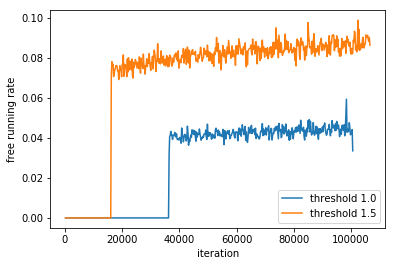

In [45]:
plt.plot(x_lst, data, label='threshold 1.0')
plt.plot(x_lst_fr15, data_fr15, label='threshold 1.5')
plt.xlabel('iteration'); plt.ylabel('free running rate')
plt.legend()
plt.show()

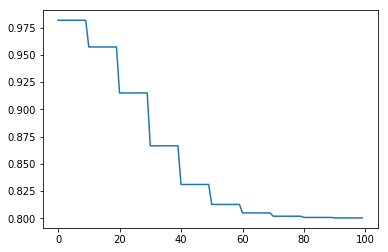

In [9]:
k = 10
ss_max = 0.2
i = np.array(range(100))
p = (1-ss_max) + ss_max * (k / (k + np.exp(i/k)))
plt.plot(i, p)
plt.show()

check BLEU

('v0000-tf-nodev-nomask', 'tst2013')


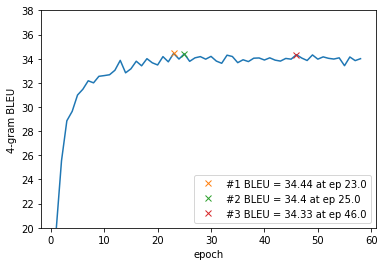

('v0000-tf-nodev-nomask', 'tst2014')


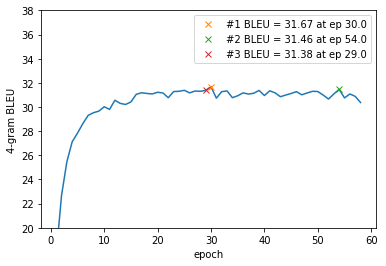

In [4]:
for exp in ['v0000-tf-nodev-nomask']:
    for tst in ['tst2013', 'tst2014']:
        print(exp, tst)
        dirSet = '/home/dawna/tts/qd212/models/Seq2seq/results/enfr/{}/{}/'.format(exp,tst)
        plot_bleu_lst(*get_ep_lst_bleu_lst(dirSet, f_bleu='bleu-DETOK.log', flag_detok_avg=True), ylim=[20,38], nb_top=3)

('v0010-mp-p2', 'tst2013')


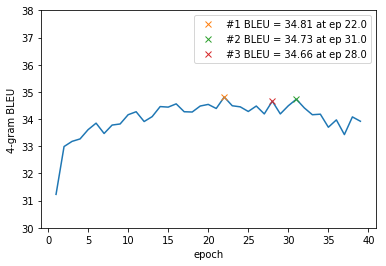

('v0010-mp-p2', 'tst2014')


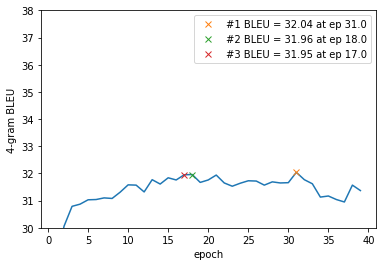

In [6]:
for exp in ['v0010-mp-p2']:
    for tst in ['tst2013', 'tst2014']:
        print(exp, tst)
        dirSet = '/home/dawna/tts/qd212/models/Seq2seq/results/enfr/{}/{}/'.format(exp,tst)
        plot_bleu_lst(*get_ep_lst_bleu_lst(dirSet, f_bleu='bleu-DETOK.log', flag_detok_avg=True), ylim=[30,38])

('v0010-mp-p2-frLmax', 'tst2013')


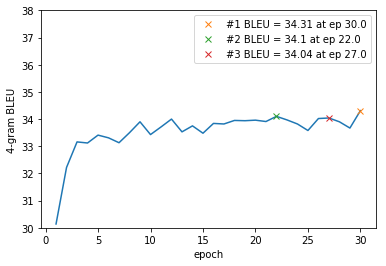

('v0010-mp-p2-frLmax', 'tst2014')


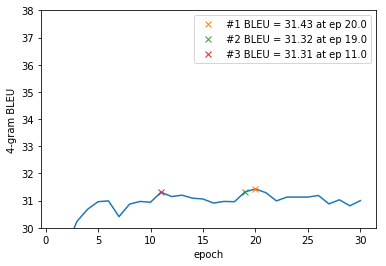

In [3]:
for exp in ['v0010-mp-p2-frLmax']:
    for tst in ['tst2013', 'tst2014']:
        print(exp, tst)
        dirSet = '/home/dawna/tts/qd212/models/Seq2seq/results/enfr/{}/{}/'.format(exp,tst)
        plot_bleu_lst(*get_ep_lst_bleu_lst(dirSet, f_bleu='bleu-DETOK.log', flag_detok_avg=True), ylim=[30,38])

In [13]:
def get_mean_std(seq):
    m = np.mean(np.array(seq))
    std = np.std(np.array(seq))
    return m, std

def get_diversity(dirFile, flag_print=False):
    with open(dirFile, 'r') as f:
        data = f.readlines()
    bleu_lst = [d.split(',')[0].split()[-1] for d in data if 'BLEU' in d]
    bleu_lst = [float(b) for b in bleu_lst]
    avg_bleu = np.mean([b for b in bleu_lst if b!=100])
    if flag_print: print('mean pair-wise bleu {:.2f}, from {}, self/100 excluded'.format(avg_bleu, bleu_lst))
    return avg_bleu, bleu_lst

# def get_diversity_lst(tmp_dirFile, exp_lst, ep_lst, tst_lst, flag_print=False):
#     avg_diversity_lst = []
#     for tst in tst_lst:
#         dirFile_lst = [tmp_dirFile.format(s=s, t=tst, e=e) for s,e in zip(exp_lst, ep_lst)]
#         diversity_lst = []
#         for dirFile in dirFile_lst:
#             diversity, bleu_lst = get_diversity(dirFile, flag_print=flag_print)
#             diversity_lst.append(diversity)
#         avg_diversity = np.mean(diversity_lst)
#         avg_diversity_lst.append(avg_diversity)
#         if flag_print: print('avg diversity over all exps: {}'.format(avg_diversity))
#     return avg_diversity_lst

def get_diversity_lst(tmp_dirFile, exp_lst, ep_lst, tst, flag_print=False):
    dirFile_lst = [tmp_dirFile.format(s=s, t=tst, e=e) for s,e in zip(exp_lst, ep_lst)]
    diversity_lst = []
    for dirFile in dirFile_lst:
        diversity, bleu_lst = get_diversity(dirFile, flag_print=flag_print)
        diversity_lst.append(diversity)
    if flag_print: print('avg diversity over all exps: {}'.format(np.mean(diversity_lst)))
    return diversity_lst

In [7]:
tf_bleu_dev = [0.1093, 0.1227, 0.1149, 0.1220, 0.1180]
tf_bleu_tst = [0.1068, 0.1206, 0.1092, 0.1189, 0.1120]
aaf_bleu_dev = [0.1170, 0.1158, 0.1119, 0.1188, 0.1164]
aaf_bleu_tst = [0.1116, 0.1104, 0.1073, 0.1120, 0.1110]
for lst in [tf_bleu_dev, tf_bleu_tst, aaf_bleu_dev, aaf_bleu_tst]:
    print('mean {:.4f}, std {:.4f}'.format(*get_mean_std(lst)))
    

tf_bleu_dev = [0.1087, 0.1069, 0.1073, 0.1067]
tf_bleu_tst = [0.1306, 0.1307, 0.1313, 0.1337]
aaf_bleu_dev = [0.1166, 0.1171, 0.1157, 0.1144, 0.1171]
aaf_bleu_tst = [0.1372, 0.1347, 0.1372, 0.1404, 0.1348]
for lst in [tf_bleu_dev, tf_bleu_tst, aaf_bleu_dev, aaf_bleu_tst]:
    print('mean {:.4f}, std {:.4f}'.format(*get_mean_std(lst)))

mean 0.1174, std 0.0049
mean 0.1135, std 0.0054
mean 0.1160, std 0.0023
mean 0.1105, std 0.0017
mean 0.1074, std 0.0008
mean 0.1316, std 0.0013
mean 0.1162, std 0.0010
mean 0.1369, std 0.0021


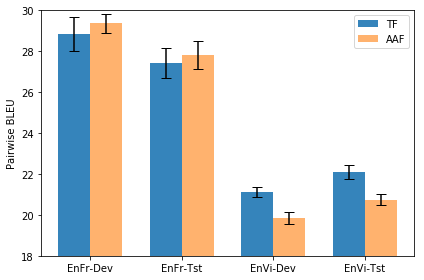

In [66]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['EnFr-Dev', 'EnFr-Tst', 'EnVi-Dev', 'EnVi-Tst']

ylabel, ymin, ymax = 'Pairwise BLEU', 18, 30
men_means = [28.86, 27.43, 21.12, 22.11]
women_means = [29.37, 27.82, 19.84, 20.75]
men_stds = [0.84, 0.75, 0.24, 0.34]
women_stds = [0.47, 0.67, 0.30, 0.29]

# ylabel, ymin, ymax = 'Entropy', 0.8, 1.7
# men_means = [0.9985, 1.0606] + [1.4897, 1.5080]
# women_means = [0.9829, 1.0341] + [1.5907, 1.5821]
# men_stds = [0.0373, 0.0474, 0.0157, 0.0122]
# women_stds = [0.0177, 0.0139, 0.0033, 0.0171]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='TF', yerr=men_stds, capsize=5, alpha=0.9)
rects2 = ax.bar(x + width/2, women_means, width, label='AAF', yerr=women_stds, capsize=5, alpha=0.6)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(ylabel)
# ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(ymin,ymax)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
#         print(rect.get_ls(), rect.get_lw())
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

check loss

In [45]:
dirFile = '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr2.0-log/dct_info.pkl'
with open(dirFile,'rb') as f:
    dct_info_2 = pickle.load(f)

dirFile = '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr4.0/dct_info.pkl'
with open(dirFile,'rb') as f:
    dct_info_4 = pickle.load(f)

dirFile = '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr8.0/dct_info.pkl'
with open(dirFile,'rb') as f:
    dct_info_8 = pickle.load(f)

for dct in [dct_info_2, dct_info_4, dct_info_8]:
    for k in dct.keys():
        dct[k] = moving_avg(dct[k], N=500)

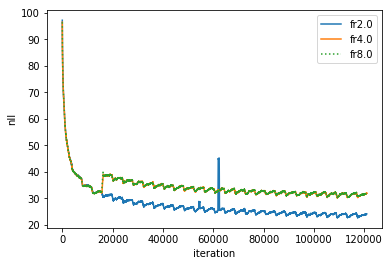

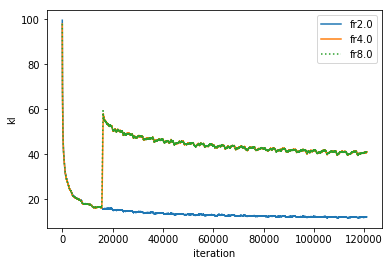

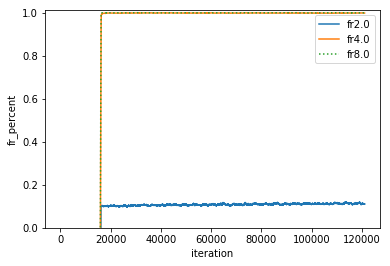

In [48]:
for k in ['nll', 'kl', 'fr_percent']:
    plt.plot(dct_info_2[k], label='fr2.0')
    plt.plot(dct_info_4[k], label='fr4.0')
    plt.plot(dct_info_8[k], ':', label='fr8.0')
    if k=='fr_percent': plt.ylim([0,1.01])
    plt.xlabel('iteration'); plt.ylabel(k)
    plt.legend()
    plt.show()

In [7]:
fr_lst = [2.0, 2.5, 3.0, 3.1, 3.15, 3.25]
dirFile_lst = ['/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr2.0-log/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr2.5/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr3.0/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr3.1/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr3.15/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0020-sched-fr3.25/dct_info.pkl'
              ]
dct_lst = []
for dirFile in dirFile_lst:
    with open(dirFile,'rb') as f:
        dct_lst.append(pickle.load(f))

for dct in dct_lst:
    for k in dct.keys():
        dct[k] = moving_avg(dct[k], N=500)

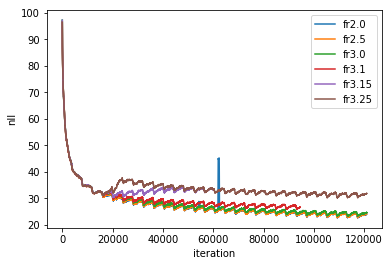

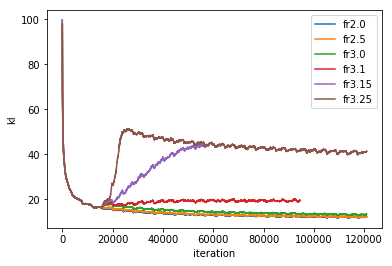

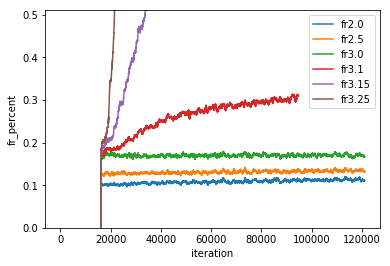

In [8]:
for k in ['nll', 'kl', 'fr_percent']:
    for fr, dct in zip(fr_lst, dct_lst):
        plt.plot(dct[k], label='fr{}'.format(fr))
    if k=='fr_percent': plt.ylim([0,0.51])
    plt.xlabel('iteration'); plt.ylabel(k)
    plt.legend()
    plt.show()

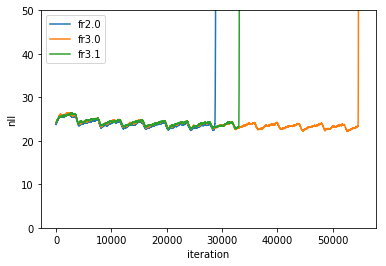

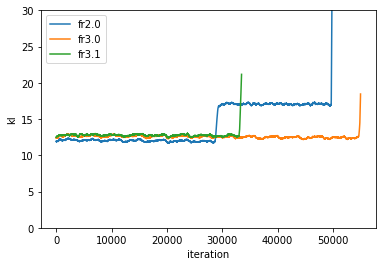

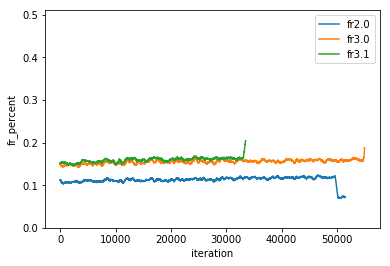

In [9]:
fr_lst = [2.0, 3.0, 3.1]
dirFile_lst = ['/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0030-sched-fr2.0-pretrain/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0030-sched-fr3.0-pretrain/dct_info.pkl', 
               '/home/dawna/tts/qd212/models/af/results/models-v9enfr/aaf-v0030-sched-fr3.1-pretrain/dct_info.pkl'
              ]
dct_lst = []
for dirFile in dirFile_lst:
    with open(dirFile,'rb') as f:
        dct_lst.append(pickle.load(f))

for dct in dct_lst:
    for k in dct.keys():
        dct[k] = moving_avg(dct[k], N=500)
        
for k in ['nll', 'kl', 'fr_percent']:
    for fr, dct in zip(fr_lst, dct_lst):
        plt.plot(dct[k], label='fr{}'.format(fr))
    if k=='fr_percent': plt.ylim([0,0.51])
    if k=='nll': plt.ylim([0,50])
    if k=='kl': plt.ylim([0,30])
    plt.xlabel('iteration'); plt.ylabel(k)
    plt.legend()
    plt.show()

check data

In [49]:
dirFile = '/home/dawna/tts/qd212/models/af/af-lib/iwslt15-enfr/iwslt15_en_fr/train.tags.en-fr.en'
with open(dirFile, 'r') as f:
    seq_src_train = f.readlines()
    
dirFile = '/home/dawna/tts/qd212/models/af/af-lib/iwslt15-enfr/iwslt15_en_fr/train.tags.en-fr.fr'
with open(dirFile, 'r') as f:
    seq_tgt_train = f.readlines()
    
seq_src_tgt_train = [s+t for s,t in zip(seq_src_train, seq_tgt_train)]
print(len(seq_src_train), len(seq_tgt_train), len(seq_src_tgt_train))

(207577, 207577, 207577)


In [36]:
dct_pair_cnt = {i:seq_src_tgt_train.count(i) for i in seq_src_tgt_train}

In [37]:
tmp_pair = dct_pair_cnt.items()
tmp_pair.sort(key = lambda x: x[1])
lst_seq_pair, lst_cnt_pair = map(list, zip(*tmp_pair))

In [39]:
print(len(tmp_pair), tmp_pair[-4:])
for limit in [1, 10, 100]:
    lst_cnt_rep = [l for l in lst_cnt_pair if l>limit]
    print(limit, len(lst_cnt_rep))

(205448, [('Thank you .\nMerci\n', 40), ('\n\n', 218), ('Thank you very much .\nMerci beaucoup .\n', 328), ('Thank you .\nMerci .\n', 788)])
(1, 356)
(10, 13)
(100, 3)


In [63]:
my_dict = {i:seq_src_train.count(i) for i in seq_src_train}

In [64]:
tmp = my_dict.items()
tmp.sort(key = lambda x: x[1])
lst_seq, lst_cnt = map(list, zip(*tmp))

(1, 629)
(10, 17)
(100, 3)
629


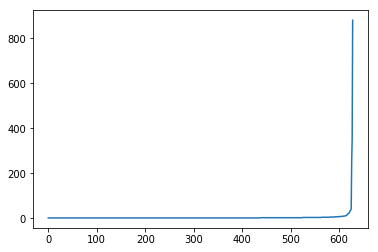

609


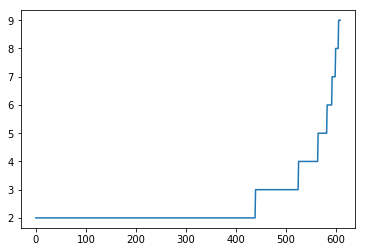

In [85]:
# print(len([l for l in lst_cnt if l>1]))
# print(len([l for l in lst_cnt if l>1]))

for limit in [1, 10, 100]:
    lst_cnt_rep = [l for l in lst_cnt if l>limit]
    print(limit, len(lst_cnt_rep))


lst_cnt_rep = [l for l in lst_cnt if l>1]
print(len(lst_cnt_rep))
plt.plot(lst_cnt_rep)
# plt.ylim(0,30)
plt.show()

lst_cnt_rep = [l for l in lst_cnt if l>1 and l<10]
print(len(lst_cnt_rep))
plt.plot(lst_cnt_rep)
# plt.ylim(0,30)
plt.show()

In [23]:
dirFile = '/home/dawna/tts/qd212/models/af/af-models/tf/trainset/epoch_24/att_score.npy'
data_enfr = np.load(dirFile)
print(data_enfr.shape)

(202536, 63, 64)


1


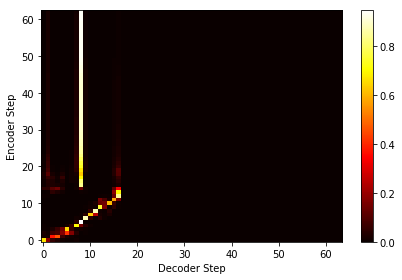

31


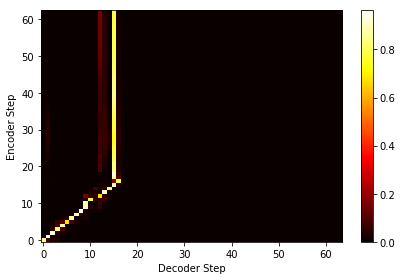

61


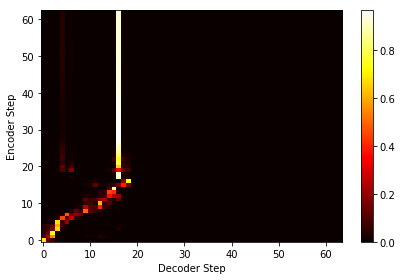

91


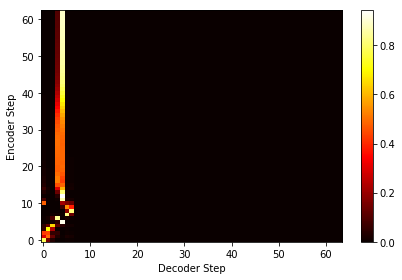

In [25]:
for idx in range(1,100,30):
    print(idx)
    plot_alignment(data_enfr[idx])

In [12]:
dirFile = '/home/dawna/tts/qd212/models/af/results/models-v0envi/v0000-tf-lr0.002/trainset/epoch_29/att_score.npy'
data = np.load(dirFile)
print(data.shape)

dirFile = '/home/dawna/tts/qd212/models/af/results/models-v0envi/v0000-tf-lr0.002/trainset/epoch_smooth_15_20_29/att_score.npy'
data = np.load(dirFile)
print(data.shape)

(127863, 63, 64)
(130946, 79, 80)


1


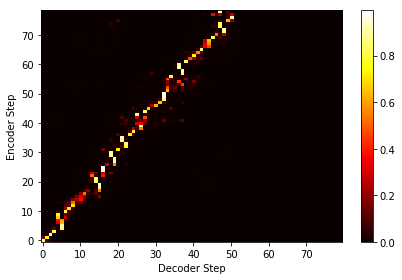

31


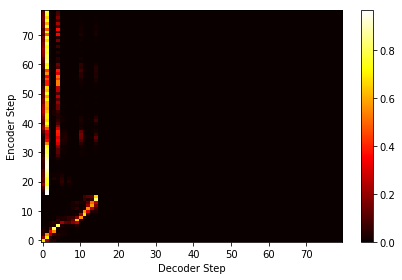

61


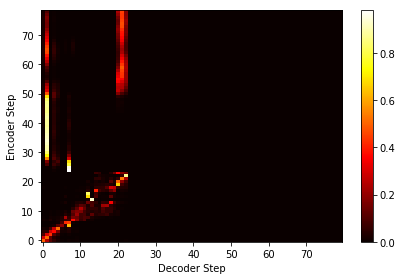

91


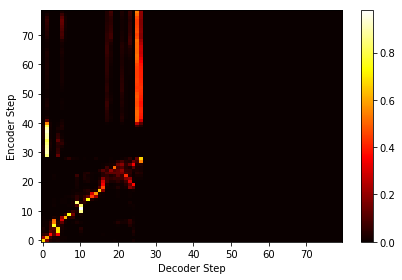

In [22]:
for idx in range(1,100,30):
    print(idx)
    plot_alignment(data[idx])